In [12]:
!git clone https://github.com/ultralytics/yolov5
!pip install -U -r yolov5/requirements.txt
!pip install hezar
!git clone https://github.com/roozbehrajabi/ALPR_Dataset.git

  Using cached hezar-0.37.0-py2.py3-none-any.whl (179 kB)
  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=69f77e83f85d3d99c3f40d99900effba51cf20e3aa54c1d5235620e22b92c27f
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Cloning into 'ALPR_Dataset'...
remote: Enumerating objects: 8947, done.
^C


In [2]:
import os

# Create a folder structure for YOLOv5 training
if not os.path.exists('data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val']:
            os.makedirs(f'data/{folder}/{split}')

In [7]:
os.rename("/content/ALPR_Dataset/YOLOv3_Dataset/Train", "/content/ALPR_Dataset/YOLOv3_Dataset/train")
os.rename("/content/ALPR_Dataset/YOLOv3_Dataset/Test", "/content/ALPR_Dataset/YOLOv3_Dataset/val")
os.rename("/content/ALPR_Dataset/YOLOv3_Dataset/Train", "/content/ALPR_Dataset/YOLOv3_Dataset/train")
os.rename("/content/ALPR_Dataset/YOLOv3_Dataset/train/1input", "/content/ALPR_Dataset/YOLOv3_Dataset/train/input")
os.rename("/content/ALPR_Dataset/YOLOv3_Dataset/train/1output", "/content/ALPR_Dataset/YOLOv3_Dataset/train/output")

In [8]:
import shutil
import os

def split_dataset(split):
    image_names=list(os.listdir(f'/content/ALPR_Dataset/YOLOv3_Dataset/{split}/input'))
    for i, image_name in enumerate(image_names):
        # Label filename
        label_name = image_name.replace('.jpg', '.txt')


        # Source paths
        source_image_path = f'/content/ALPR_Dataset/YOLOv3_Dataset/{split}/input/{image_name}'
        source_label_path = f'/content/ALPR_Dataset/YOLOv3_Dataset/{split}/output/YOLO_darknet/{label_name}'

        # Destination paths
        target_image_folder = f'data/images/{split}'
        target_label_folder = f'data/labels/{split}'

        # Copy files
        shutil.copy(source_image_path, target_image_folder)
        shutil.copy(source_label_path, target_label_folder)

# Cat data
split_dataset("train")
split_dataset("val")

In [ ]:
!python yolov5/train.py --data data.yaml --weights yolov5s.pt --epochs 100 --batch 64 --freeze 10

In [ ]:
!cp -r /content/yolov5/runs/train/exp2 "/content/drive/MyDrive/"

cp: target 'True' is not a directory


In [9]:
!python yolov5/detect.py --weights /content/drive/MyDrive/exp2/weights/best.pt --source /content/data/images/val/000002.jpg

detect: weights=['/content/drive/MyDrive/exp2/weights/best.pt'], source=/content/data/images/val/000002.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-313-g712de55a Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/data/images/val/000002.jpg: 640x640 1 cat, 12.6ms
Speed: 0.7ms pre-process, 12.6ms inference, 1055.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/exp


In [1]:
%cd yolov5
import csv
import os
import platform
import sys
from pathlib import Path

import torch

FILE = Path("/content").resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from ultralytics.utils.plotting import Annotator, colors, save_one_box

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams
from utils.general import (
    LOGGER,
    Profile,
    check_file,
    check_img_size,
    check_imshow,
    check_requirements,
    colorstr,
    cv2,
    increment_path,
    non_max_suppression,
    print_args,
    scale_boxes,
    strip_optimizer,
    xyxy2xywh,
)
from utils.torch_utils import select_device, smart_inference_mode


@smart_inference_mode()
def run(
    weights=ROOT / "yolov5s.pt",  # model path or triton URL
    source=ROOT / "data/images",  # file/dir/URL/glob/screen/0(webcam)
    data=ROOT / "data/coco128.yaml",  # dataset.yaml path
    imgsz=(640, 640),  # inference size (height, width)
    conf_thres=0.25,  # confidence threshold
    iou_thres=0.45,  # NMS IOU threshold
    max_det=1000,  # maximum detections per image
    device="",  # cuda device, i.e. 0 or 0,1,2,3 or cpu
    view_img=False,  # show results
    save_txt=False,  # save results to *.txt
    save_csv=False,  # save results in CSV format
    save_conf=False,  # save confidences in --save-txt labels
    save_crop=False,  # save cropped prediction boxes
    nosave=False,  # do not save images/videos
    classes=None,  # filter by class: --class 0, or --class 0 2 3
    agnostic_nms=False,  # class-agnostic NMS
    augment=False,  # augmented inference
    visualize=False,  # visualize features
    update=False,  # update all models
    project=ROOT / "runs/detect",  # save results to project/name
    name="exp",  # save results to project/name
    exist_ok=False,  # existing project/name ok, do not increment
    line_thickness=3,  # bounding box thickness (pixels)
    hide_labels=False,  # hide labels
    hide_conf=False,  # hide confidences
    half=False,  # use FP16 half-precision inference
    dnn=False,  # use OpenCV DNN for ONNX inference
    vid_stride=1,  # video frame-rate stride
):
    source = str(source)
    save_img = not nosave and not source.endswith(".txt")  # save inference images
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(("rtsp://", "rtmp://", "http://", "https://"))
    webcam = source.isnumeric() or source.endswith(".streams") or (is_url and not is_file)
    screenshot = source.lower().startswith("screen")
    if is_url and is_file:
        source = check_file(source)  # download

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / "labels" if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    # Dataloader
    bs = 1  # batch_size
    if webcam:
        view_img = check_imshow(warn=True)
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
        bs = len(dataset)
    elif screenshot:
        dataset = LoadScreenshots(source, img_size=imgsz, stride=stride, auto=pt)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
    seen, windows, dt = 0, [], (Profile(device=device), Profile(device=device), Profile(device=device))
    for path, im, im0s, vid_cap, s in dataset:
        with dt[0]:
            im = torch.from_numpy(im).to(model.device)
            im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim
            if model.xml and im.shape[0] > 1:
                ims = torch.chunk(im, im.shape[0], 0)

        # Inference
        with dt[1]:
            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            if model.xml and im.shape[0] > 1:
                pred = None
                for image in ims:
                    if pred is None:
                        pred = model(image, augment=augment, visualize=visualize).unsqueeze(0)
                    else:
                        pred = torch.cat((pred, model(image, augment=augment, visualize=visualize).unsqueeze(0)), dim=0)
                pred = [pred, None]
            else:
                pred = model(im, augment=augment, visualize=visualize)
        # NMS
        with dt[2]:
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

        # Process predictions
        plates=[]
        for i, det in enumerate(pred):  # per image
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f"{i}: "
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, "frame", 0)

            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, 5].unique():
                    n = (det[:, 5] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    c = int(cls)  # integer class
                    label = names[c] if hide_conf else f"{names[c]}"
                    confidence = float(conf)
                    anchors=[int(j) for j in xyxy ]
                    if confidence>0.5:
                        plates.append(im0[anchors[1]:anchors[3],anchors[0]:anchors[2],:])
        return plates


im=run(weights="/content/drive/MyDrive/exp2/weights/best.pt", source="/content/car.jpg")

/content/yolov5


YOLOv5 🚀 v7.0-313-g712de55a Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded


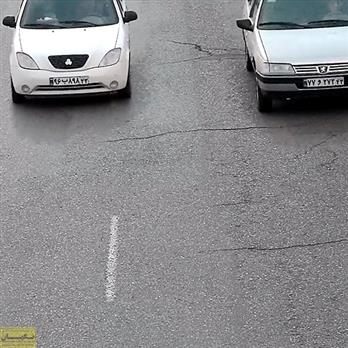

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
Image.open("/content/car.jpg")


In [116]:
import pandas as pd
data={'plate':['۹۶ب۸۹۸۲۳','۷۷و۲۷۲۴۳'],"owner":["Ali Samadi","Sanaz Abbasi"],"penalty":[120,25],"seen_today":[False,False]}
df=pd.DataFrame(data)
df.set_index('plate', inplace=True)
df

,owner,penalty,seen_today
plate,,,
۹۶ب۸۹۸۲۳,Ali Samadi,120,False
۷۷و۲۷۲۴۳,Sanaz Abbasi,25,False


In [119]:
from hezar.models import Model
import datetime

def get_today_type():
    x = datetime.datetime.now()
    days={"Saturday":0,"Sunday":1,"Monday":0,"Tuesday":1,"Wednesday":0,"Thursday":1,"Friday":0}
    return days[x.strftime("%A")]
model = Model.load("hezarai/crnn-fa-64x256-license-plate-recognition")
answer=[model.predict(im)[i]['text'][::-1] for i in range(len(im))]
today=get_today_type()
for i in range(len(answer)):
    last_number=answer[i][-3:-2]
    if int(last_number)%2!=today and not df.loc[answer[i]]['seen_today']:
        df.loc[answer[i],'seen_today']=True
        df.loc[answer[i],'penalty']+=120




/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [120]:
df

,owner,penalty,seen_today
plate,,,
۹۶ب۸۹۸۲۳,Ali Samadi,240,True
۷۷و۲۷۲۴۳,Sanaz Abbasi,145,True
